# Description
Trains and evaluates ALBERT token classification model with variant-only Wikipedia Homograph data only; one model for all labels.

### Imports

In [1]:
import os
import sys
import logging
from pathlib import Path
import re
from glob import glob
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple, TextIO
from transformers import AlbertForTokenClassification
from transformers import AlbertTokenizerFast, EvalPrediction
from transformers import Trainer, TrainingArguments
from transformers import AdamW
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
#from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score
#from pytorch_lightning.metrics.functional.classification import accuracy

### Variables

In [2]:
#Paths 
WHD_BERT_DATA = "C:/Users/jseal/Dev/dissertation/Data/WHD_ALBERT/variant_stratified/"
WHD = 'C:/Users/jseal/Dev/dissertation/Data/WikipediaHomographData/data/'

#Txt splits
TRAIN_TXT = WHD_BERT_DATA + "train.txt"
DEV_TXT = WHD_BERT_DATA + "dev.txt"
TEST_TXT = WHD_BERT_DATA + "test.txt"

#Logging path
LOGS = './whd-variant-stratified-albert-model_logs'

#Labels file
LABELS = WHD_BERT_DATA + "labels.txt"

#Homographs
#whd_df = pd.read_csv(WHD + 'WikipediaHomographData.csv')
#homographs = whd_df.drop_duplicates(subset='homograph')['homograph'].tolist()

# Model Variables
MAX_LENGTH = 128 #@param {type: "integer"}
BATCH_SIZE = 16 #@param {type: "integer"}
NUM_EPOCHS = 3 #@param {type: "integer"}
SAVE_STEPS = 100 #@param {type: "integer"}
LOGGING_STEPS = 100 #@param {type: "integer"}
SEED_1 = 15
SEED = 42 #@param {type: "integer"}
SEED_2 = 30
SEED_3 = 1234
SEED_4 = 500
STEPS = "steps"
EVAL_STEPS = 100
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01

MODEL_NAME = "albert-base-v2"
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

logger = logging.getLogger(__name__)

cuda:0


### Functions & classes

In [3]:
def read_set(file_path):
    file_path = Path(file_path)

    raw_text = file_path.read_text(encoding="utf8").strip()
    raw_docs = re.split(r'\n\t?\n', raw_text)
    token_docs = []
    tag_docs = []
    for doc in raw_docs:
        tokens = []
        tags = []
        for line in doc.split('\n'):
            token, tag = line.split('\t')
            if token.isalpha():
                tokens.append(token)
                tags.append(tag)
        token_docs.append(tokens)
        tag_docs.append(tags)

    return token_docs, tag_docs

def encode_tags(tags, encodings):
    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = [] 
    for doc_labels, doc_offset, e in zip(labels, encodings.offset_mapping, encodings.encodings):
        indices = []
        for i, tok in enumerate(e.tokens):
            if len(tok) == 1:
                if (tok == '▁'):
                    indices.append(i)

        tokens = [v for i, v in enumerate(e.tokens) if i not in indices]
        doc_offset = [v for i, v in enumerate(doc_offset) if i not in indices]
        for i in range(len(indices)): 
            tokens.insert(-1, '<pad>')
            doc_offset.insert(-1, (0,0))
        # create an empty array of -100
        doc_enc_labels = np.ones(len(doc_offset),dtype=int) * -100
        arr_offset = np.array(doc_offset)   

        #Set labels whose first offset position is 0 and second is not 0
        if len(doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)]) == 16:
             print('doc labels')
             print(doc_labels)
             print('tags')
             tags = [id2tag[tag] for tag in doc_labels]
             print(list(tags))
             print('doc offset')
             print(doc_offset)
             print('e.tokens')
             print(e.tokens)
             print('tokens')
             print(tokens)
             if "_" in e.tokens:
                 print(e.tokens.index("_"))
        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels
        encoded_labels.append(doc_enc_labels.tolist())
    
    return encoded_labels

class WHDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
       # self.tokenizer = tokenizer
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
def align_predictions(predictions: np.ndarray, 
                      label_ids: np.ndarray) -> Tuple[List[int], List[int], List[str]]:
    preds = np.argmax(predictions, axis=2)

    batch_size, seq_len = preds.shape

    out_label_list = [[] for _ in range(batch_size)]
    preds_list = [[] for _ in range(batch_size)]

    for i in range(batch_size):
        for j in range(seq_len):
            if label_ids[i, j] != nn.CrossEntropyLoss().ignore_index:
                out_label_list[i].append(id2tag[label_ids[i][j]])
                preds_list[i].append(id2tag[preds[i][j]])
    return preds_list, out_label_list

def homograph_check(preds_list, out_label_list):
    '''Check that predictions to be evaluated are homographs, 
    not tokens from the sentence provided as context.'''
    pred_labels = zip(preds_list, out_label_list)
    unique_tags = [label.strip("\n") for label in open(LABELS).readlines()]
    preds = []
    labels = []
    for e in pred_labels:
        pred_label_pair = zip(e[0], e[1])
        for pred, label in pred_label_pair:
            if label is not 'O':
                preds.append(pred)
                labels.append(label)
    return labels, preds
    
def compute_metrics(p: EvalPrediction) -> Dict:
    '''Only compute metrics on homograph pronunciation predictions'''
    preds_list, labels_list = align_predictions(p.predictions, p.label_ids)
    targets, preds = homograph_check(preds_list, labels_list)
#     preds = [tag2id[pred] for pred in preds]
#     targets = [tag2id[target] for target in targets]
#     preds = torch.as_tensor(preds)
#     targets = torch.as_tensor(targets)
    return {
        "accuracy_score": accuracy_score(targets, preds),
        "balanced_accuracy_score": balanced_accuracy_score(targets, preds),
        #"micro_auc_roc": roc_auc_score(targets, preds, average='micro')
#         "micro_accuracy": accuracy(preds, targets, class_reduction='micro', num_classes=len(unique_tags)),
#         "macro_accuracy": accuracy(preds, targets, class_reduction='macro', num_classes=len(unique_tags)),
    }

def write_predictions_to_file(writer: TextIO, test_input_reader: TextIO, preds_list: List):
    example_id = 0
    for line in test_input_reader:
        if line.startswith("-DOCSTART-") or line == "" or line == "\n":
            writer.write(line)
            if not preds_list[example_id]:
                example_id += 1
        elif preds_list[example_id]:
            output_line = line.split()[0] + " " + preds_list[example_id].pop(0) + "\n"
            writer.write(output_line)
        else:
            logger.warning("Maximum sequence length exceeded: No prediction for '%s'.", line.split()[0])

# Script

In [4]:
#Get unique labels, enumeration/IDs, and make mappings
unique_tags = [label.strip("\n") for label in open(LABELS).readlines()]
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [5]:
#Make separate lists of aligned texts and tags
train_texts, train_tags = read_set(TRAIN_TXT)
dev_texts, dev_tags = read_set(DEV_TXT)
test_texts, test_tags = read_set(TEST_TXT)

In [6]:
#Make encodings for text 
tokenizer = AlbertTokenizerFast.from_pretrained(MODEL_NAME,add_prefix_space=True)
train_encodings = tokenizer(train_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
dev_encodings = tokenizer(dev_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)

In [7]:
#Make encodings for labels
train_labels = encode_tags(train_tags, train_encodings)
dev_labels = encode_tags(dev_tags, dev_encodings)

doc labels
[256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 2, 256, 256, 256, 256, 256]
tags
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'abuses_nou', 'O', 'O', 'O', 'O', 'O']
doc offset
[(0, 0), (0, 5), (0, 3), (0, 9), (0, 2), (0, 4), (0, 5), (0, 11), (0, 2), (0, 3), (3, 8), (0, 3), (0, 5), (5, 6), (0, 3), (0, 9), (0, 2), (0, 3), (0, 9), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
e.tokens
['[CLS]', '▁frank', '▁and', '▁outspoken', '▁he', '▁took', '▁every', '▁opportunity', '▁to', '▁den', 'ounce', '▁the', '▁abuse', 's', '▁and', '▁arrogance', '▁of', '▁the', '▁spaniards', '[SEP]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
tokens
['[CLS]', '▁frank', '▁and', '▁outspoken', '▁he', '▁took', '▁e

doc labels
[256, 256, 256, 256, 256, 256, 256, 256, 43, 256, 256, 256, 256, 256, 256, 256]
tags
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'combine_vrb', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
doc offset
[(0, 0), (0, 4), (0, 5), (0, 3), (0, 5), (0, 3), (0, 5), (0, 6), (0, 2), (0, 7), (0, 7), (0, 3), (0, 5), (0, 2), (0, 4), (0, 6), (0, 7), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
e.tokens
['[CLS]', '▁from', '▁about', '▁age', '▁three', '▁the', '▁child', '▁begins', '▁to', '▁combine', '▁circles', '▁and', '▁lines', '▁to', '▁make', '▁simple', '▁figures', '[SEP]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
tokens
['[CLS]', '▁from', '▁about', '▁age', '▁three', '▁the', '▁chi

['O', 'O', 'O', 'O', 'decrease_vrb', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
doc offset
[(0, 0), (0, 3), (0, 11), (0, 7), (0, 7), (0, 8), (0, 4), (0, 9), (0, 11), (0, 7), (0, 4), (0, 5), (0, 3), (0, 4), (0, 2), (0, 5), (0, 6), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
e.tokens
['[CLS]', '▁the', '▁oscillation', '▁periods', '▁broadly', '▁decrease', '▁with', '▁effective', '▁temperature', '▁ranging', '▁from', '▁about', '▁min', '▁down', '▁to', '▁about', '▁minute', '[SEP]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
tokens
['[CLS]', '▁the', '▁oscillation', '▁periods', '▁broadly', '▁decrease', '▁with', '▁effective', '▁temperature', '▁ranging', '▁from', 

doc labels
[256, 256, 256, 256, 256, 114, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]
tags
['O', 'O', 'O', 'O', 'O', 'extract_nou', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
doc offset
[(0, 0), (0, 3), (0, 5), (0, 3), (0, 4), (0, 2), (0, 7), (0, 3), (0, 3), (0, 5), (0, 2), (0, 3), (0, 6), (0, 3), (0, 3), (0, 5), (0, 5), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
e.tokens
['[CLS]', '▁its', '▁wines', '▁are', '▁rich', '▁in', '▁extract', '▁and', '▁are', '▁found', '▁as', '▁dry', '▁medium', '▁dry', '▁and', '▁sweet', '▁wines', '[SEP]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
tokens
['[CLS]', '▁its', '▁wines', '▁are', '▁rich', '▁in', '▁extract', '▁and',

doc labels
[256, 256, 256, 256, 149, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]
tags
['O', 'O', 'O', 'O', 'invite_vrb', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
doc offset
[(0, 0), (0, 3), (0, 7), (0, 2), (0, 2), (0, 6), (0, 5), (0, 7), (0, 8), (0, 7), (0, 2), (0, 4), (0, 5), (0, 3), (0, 5), (0, 2), (0, 7), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
e.tokens
['[CLS]', '▁its', '▁purpose', '▁is', '▁to', '▁invite', '▁young', '▁english', '▁speaking', '▁authors', '▁to', '▁live', '▁write', '▁and', '▁teach', '▁in', '▁leipzig', '[SEP]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
tokens
['[CLS]', '▁its', '▁purpose', '▁is', '▁to', '▁invite', '▁yo

doc labels
[256, 256, 256, 256, 256, 256, 256, 256, 184, 256, 256, 256, 256, 256, 256, 256]
tags
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'polish_geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
doc offset
[(0, 0), (0, 1), (1, 4), (4, 5), (5, 8), (8, 9), (0, 7), (0, 2), (2, 3), (3, 7), (7, 8), (0, 4), (0, 6), (0, 4), (4, 6), (0, 2), (0, 1), (0, 6), (0, 6), (0, 3), (0, 6), (0, 7), (0, 2), (0, 3), (0, 3), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
e.tokens
['[CLS]', '▁z', 'dzi', 's', 'law', 'a', '▁barbara', '▁so', 's', 'nick', 'a', '▁born', '▁august', '▁kali', 'sz', '▁is', '▁a', '▁polish', '▁singer', '▁who', '▁became', '▁popular', '▁in', '▁the', '▁and', '[SEP]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
tokens
['[CLS]', '▁z', 'dzi', 's', 'law', 'a', '▁barbara', '▁so', 's', 'nick', 'a', '▁born', '▁august'

[256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 223, 256, 256, 256, 256]
tags
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'sake', 'O', 'O', 'O', 'O']
doc offset
[(0, 0), (0, 2), (0, 4), (0, 1), (0, 2), (0, 4), (0, 2), (0, 2), (0, 1), (0, 9), (0, 3), (0, 3), (0, 4), (0, 2), (0, 5), (0, 1), (0, 9), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
e.tokens
['[CLS]', '▁he', '▁said', '▁i', '▁do', '▁want', '▁to', '▁be', '▁a', '▁celebrity', '▁for', '▁the', '▁sake', '▁of', '▁being', '▁a', '▁celebrity', '[SEP]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
tokens
['[CLS]', '▁he', '▁said', '▁i', '▁do', '▁want', '▁to', '▁be', '▁a', '▁celebrity', '▁for', '▁the',

[256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 51, 256, 256]
tags
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'confines_vrb', 'O', 'O']
doc offset
[(0, 0), (0, 3), (0, 5), (0, 1), (0, 3), (0, 4), (0, 3), (0, 4), (0, 1), (0, 5), (0, 3), (0, 2), (0, 4), (0, 4), (0, 8), (0, 3), (0, 4), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]
e.tokens
['[CLS]', '▁she', '▁wears', '▁a', '▁red', '▁flat', '▁hat', '▁over', '▁a', '▁small', '▁cap', '▁or', '▁', 'caul', '▁that', '▁confines', '▁her', '▁hair', '[SEP]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
tokens
['[CLS]', '▁she', '▁wears', '▁a', '▁red', '▁flat', '▁hat', '▁over', '▁a', '▁small', '▁cap', '▁or', 'caul', '▁that', '▁confines', '▁her', '▁hair', '[SEP]', '<pad>', '<pad>', '<pa

In [8]:
#Make datasets
train_encodings.pop("offset_mapping") # don't want to pass this to the model
dev_encodings.pop("offset_mapping")
train_dataset = WHDataset(train_encodings, train_labels)
dev_dataset = WHDataset(dev_encodings, dev_labels)
#print(dev_dataset[0])

In [9]:
#Instantiate model, training args and trainer; train and evaluate
model = AlbertForTokenClassification.from_pretrained(MODEL_NAME,
                                                   num_labels=len(unique_tags))
model.to(device)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir='./whd-variant-stratified-albert-model',    # output directory
    num_train_epochs=NUM_EPOCHS,              # total # of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=WARMUP_STEPS,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,                # strength of weight decay
    logging_dir=LOGS,                         # directory for storing logs
    evaluation_strategy=STEPS,
    eval_steps=EVAL_STEPS,
    seed=SEED_1,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,                         # instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForTokenClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably

Step,Training Loss,Validation Loss,Accuracy Score,Balanced Accuracy Score
100,No log,0.538157,0.000000,0.000000
200,No log,0.423525,0.004484,0.002131
300,No log,0.302519,0.240658,0.147997
400,No log,0.206741,0.522422,0.315401
500,0.786726,0.143373,0.714499,0.456884
600,0.786726,0.108361,0.739163,0.501497
700,0.786726,0.088478,0.755605,0.517169
800,0.786726,0.069647,0.789238,0.548503
900,0.786726,0.061138,0.841555,0.614010
1000,0.073048,0.062395,0.846039,0.639254


C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814

C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


{'eval_loss': 0.02987072430551052,
 'eval_accuracy_score': 0.9185351270553064,
 'eval_balanced_accuracy_score': 0.7767418887536075,
 'epoch': 3.0}

In [10]:
from statistics import mean 
predictions, label_ids, metrics = trainer.predict(dev_dataset)
preds_list, targets_list = align_predictions(predictions, label_ids)
targets_list, preds_list = homograph_check(preds_list, targets_list)

output_results_file = os.path.join(training_args.output_dir, "results.txt")
# if trainer.is_world_master():
#     with open(output_results_file, "w", encoding="utf8") as writer:
#         for key, value in metrics.items():
#             logger.info("  %s = %s", key, value)
#             writer.write("%s = %s\n" % (key, value))

# Save predictions
#output_predictions_file = os.path.join(training_args.output_dir, "predictions.txt")
to_df = zip(preds_list, targets_list)
print('Micro Accuracy')
df = pd.DataFrame(to_df, columns=['Preds', 'Targets'])
df_correct = df[df['Preds'] == df['Targets']]
print(len(df_correct)/len(df))
print('Macro Accuracy')
group_accuracies_for_mean = []
group_accuracies = []
for idx, group in df.groupby('Targets'):
    grp = {}
    grp["wordid"] = idx
    print(idx)
    correct = group[group['Preds'] == group['Targets']]
    accuracy = len(correct)/len(group)
    print(accuracy)
    grp["accuracy"] = accuracy
    group_accuracies.append(grp)
    group_accuracies_for_mean.append(accuracy)
print(mean(group_accuracies_for_mean))
accuracies_df = pd.DataFrame(group_accuracies)

C:\Users\jseal\anaconda3\envs\dissertation_huggingface\lib\site-packages\sklearn\metrics\_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Micro Accuracy
0.9185351270553064
Macro Accuracy
abuse_nou
1.0
abuse_vrb
1.0
abuses_nou
1.0
abuses_vrb
1.0
advocate_nou
1.0
advocate_vrb
1.0
affect
1.0
affect_nou-psy
0.5
affiliate_nou
1.0
affiliate_vrb
0.0
aged
1.0
aged_adj
0.0
aggregate_adj-nou
1.0
aggregate_vrb
1.0
alternate_adj-nou
0.9
alternate_vrb
0.0
analyses_nou
1.0
analyses_vrb
1.0
animate_adj-nou
0.75
animate_vrb
0.8333333333333334
approximate_adj-nou
1.0
approximate_vrb
1.0
articulate_adj
1.0
articulate_vrb
1.0
associate_adj-nou
1.0
associate_vrb
1.0
attribute_nou
1.0
attribute_vrb
1.0
axes_nou
0.8
axes_nou-vrb
0.4
bass
1.0
bass_corp
1.0
blessed_adj
0.75
blessed_vrb
1.0
bow_nou-knot
0.75
bow_nou-ship
0.3333333333333333
buffet_nou
1.0
buffet_vrb
0.0
celtic
1.0
celtic_adj-nou-sports
1.0
close_adj-nou
0.9
close_vrb
0.0
combine_nou
1.0
combine_vrb
1.0
compound_nou
0.8181818181818182
compound_vrb
0.0
compress
1.0
compress_nou
0.0
conduct_nou
1.0
conduct_vrb
0.8
confines_nou
1.0
confines_vrb
1.0
conflict_nou
1.0
conflict_vrb
0.0
c

In [11]:
output_predictions_file = os.path.join('./whd-variant-stratified-albert-model', "predictions.txt")

In [12]:
output_predictions_file

'./whd-variant-stratified-albert-model\\predictions.txt'

In [13]:
pd.set_option('display.max_rows', None)

In [14]:
accuracies_df.sort_values("accuracy")

,wordid,accuracy
153,laminate_vrb,0.000000
62,content_adj-nou-vrb,0.000000
112,expose_nou,0.000000
111,export_vrb,0.000000
179,perfume_vrb,0.000000
184,polish,0.000000
99,dove_vrb,0.000000
95,discount_vrb,0.000000
37,buffet_vrb,0.000000
229,subordinate_vrb,0.000000


In [15]:
hids = pd.read_csv("C:/Users/jseal/Dev/dissertation/Data_Exploration/WHD/hids.csv")

In [16]:
hids_acc = pd.merge(hids, accuracies_df, on='wordid')

In [17]:
hids_acc.sort_values(["accuracy"])

,Unnamed: 0,homograph,wordid,wordid_count,ttl,percent_ttl,accuracy
75,1,correlate,correlate_nou,7,90,0.077778,0.000000
191,1,present,present_vrb,7,90,0.077778,0.000000
93,1,discharge,discharge_vrb,10,90,0.111111,0.000000
193,1,produce,produce_nou,6,90,0.066667,0.000000
85,1,deliberate,deliberate_vrb,3,89,0.033708,0.000000
213,1,reject,reject_nou,5,86,0.058140,0.000000
63,1,content,content_adj-nou-vrb,1,90,0.011111,0.000000
219,1,retard,retard_nou,14,85,0.164706,0.000000
57,1,conscript,conscript_vrb,14,89,0.157303,0.000000
55,1,conjugate,conjugate_vrb,4,90,0.044444,0.000000


In [18]:
hids_acc = hids_acc[hids_acc['accuracy'] < 1.0]

In [19]:
hids_acc.to_csv('C:/Users/jseal/Dev/dissertation/Data/WHD_ALBERT/classes_w_accuracy_below_1-albert.tsv', sep='\t')

In [20]:
hids_acc_prevalence = hids_acc[["wordid", "percent_ttl"]]
hids_acc_acc = hids_acc[["wordid", "accuracy"]]

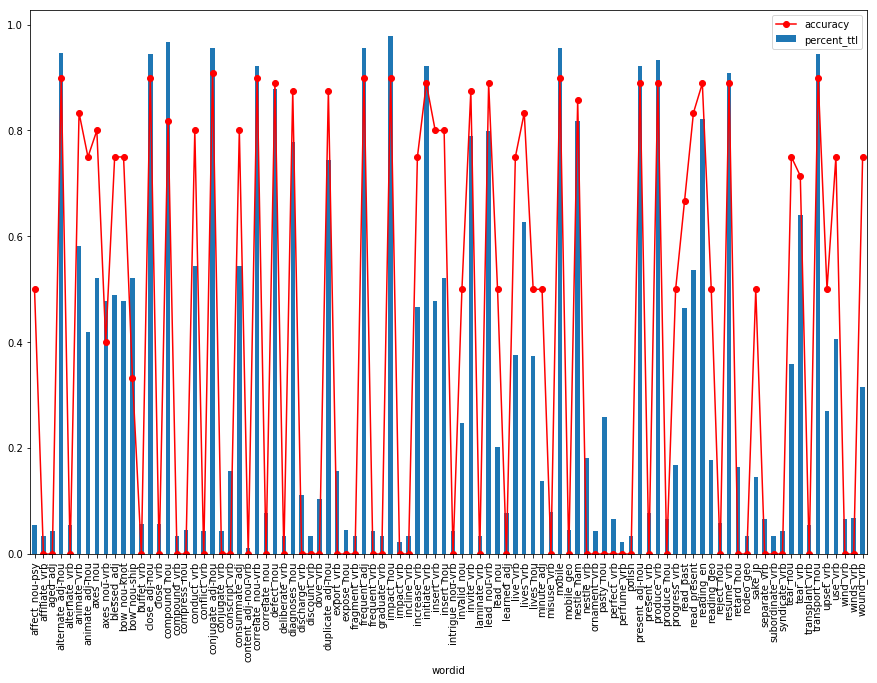

In [21]:
import matplotlib.pylab as plt
%matplotlib inline  

ax = hids_acc_acc.plot(
    x='wordid', linestyle='-', marker='o', color="red")
hids_acc_prevalence.plot(x='wordid', kind='bar', ax=ax, figsize=(15,10))

plt.show()

In [22]:
hids_acc = pd.merge(hids, accuracies_df, on='wordid')
homs = hids_acc[hids_acc["percent_ttl"] < 0.2]['homograph'].tolist()
homs

['abuse',
 'abuses',
 'advocate',
 'affect',
 'affiliate',
 'aged',
 'aggregate',
 'alternate',
 'analyses',
 'approximate',
 'associate',
 'bass',
 'buffet',
 'close',
 'combine',
 'compound',
 'compress',
 'confines',
 'conflict',
 'conjugate',
 'conscript',
 'construct',
 'content',
 'contest',
 'convert',
 'convict',
 'correlate',
 'defect',
 'degenerate',
 'delegate',
 'deliberate',
 'discharge',
 'discount',
 'document',
 'dove',
 'escort',
 'excuse',
 'exploit',
 'export',
 'expose',
 'fragment',
 'frequent',
 'graduate',
 'impact',
 'implant',
 'implement',
 'incline',
 'increment',
 'initiate',
 'intrigue',
 'laminate',
 'learned',
 'minute',
 'misuse',
 'mobile',
 'nestle',
 'ornament',
 'perfect',
 'perfume',
 'polish',
 'present',
 'produce',
 'progress',
 'protest',
 'reading',
 'rebel',
 'record',
 'refuse',
 'reject',
 'rerelease',
 'resume',
 'retard',
 'rodeo',
 'sake',
 'separate',
 'subordinate',
 'syndicate',
 'transplant',
 'transport',
 'uses',
 'wind',
 'winds']

In [23]:
len(homs)

82

In [24]:
hids_acc['homograph'].nunique()

128

# Train and eval together

In [25]:
hids = pd.read_csv("C:/Users/jseal/Dev/dissertation/Data_Exploration/WHD/train_eval_hids.csv")

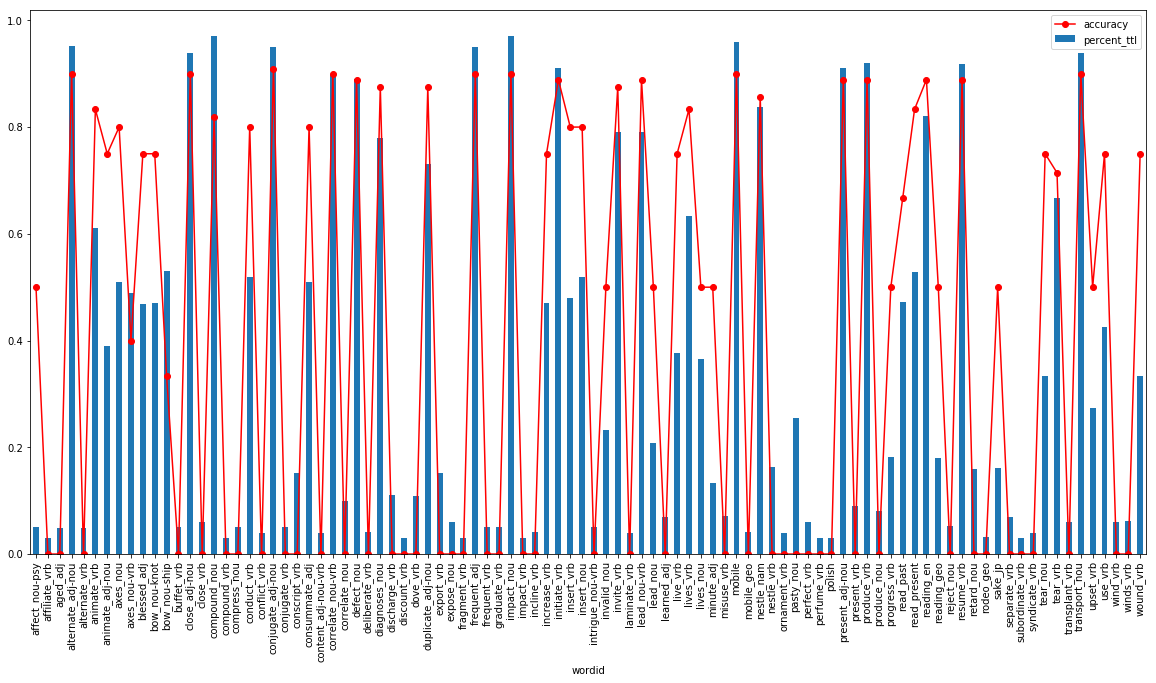

In [26]:
hids_acc = pd.merge(hids, accuracies_df, on='wordid')
hids_acc = hids_acc[hids_acc['accuracy'] < 1.0]
hids_acc_prevalence = hids_acc[["wordid", "percent_ttl"]]
hids_acc_acc = hids_acc[["wordid", "accuracy"]]
ax = hids_acc_acc.plot(
    x='wordid', linestyle='-', marker='o', color="red")
hids_acc_prevalence.plot(x='wordid', kind='bar', ax=ax, figsize=(20,10))

plt.show()

In [27]:
fig = hids_acc_prevalence.plot(x='wordid', kind='bar', ax=ax, figsize=(20,10)).get_figure()

fig.savefig('albert_low_acc_low_perc.pdf')

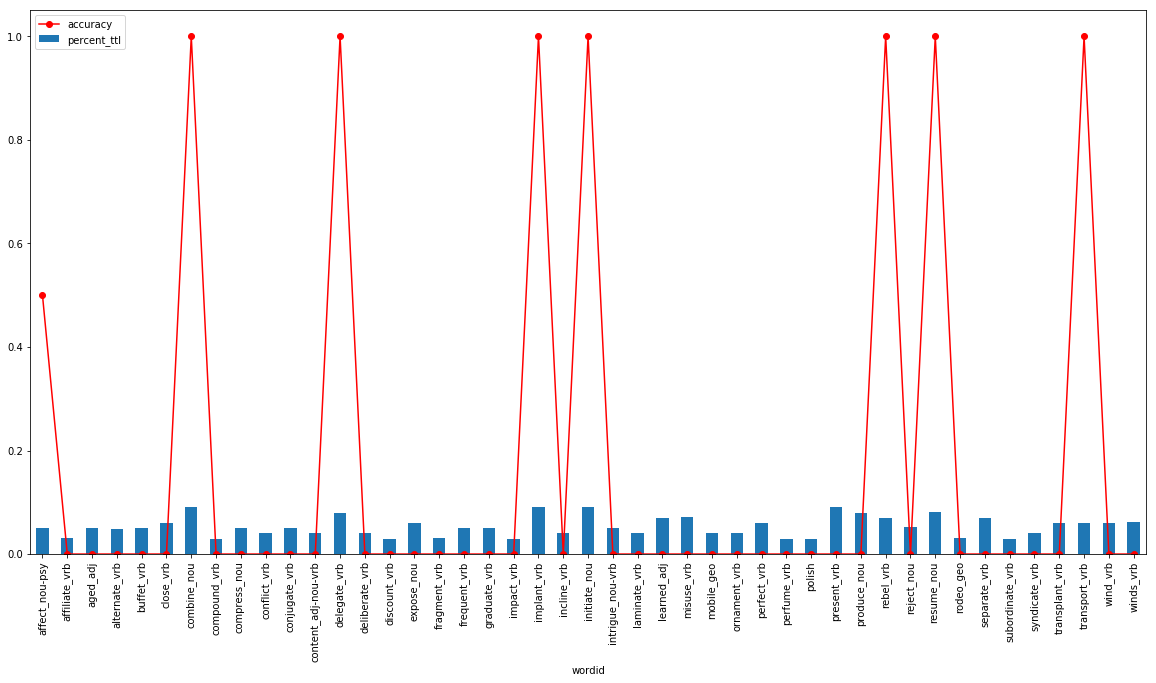

In [28]:
hids_acc = pd.merge(hids, accuracies_df, on='wordid')
hids_acc = hids_acc[hids_acc['percent_ttl'] < 0.1]
hids_acc_prevalence = hids_acc[["wordid", "percent_ttl"]]
hids_acc_acc = hids_acc[["wordid", "accuracy"]]
ax = hids_acc_acc.plot(
    x='wordid', linestyle='-', marker='o', color="red")
#hids_acc_prevalence.plot(x='wordid', kind='bar', ax=ax, figsize=(20,10))
fig = hids_acc_prevalence.plot(x='wordid', kind='bar', ax=ax, figsize=(20,10)).get_figure()

fig.savefig('albert_low_acc_low_perc.pdf')
#plt.show()

In [ ]:
#WITH SEED_2
#Instantiate model, training args and trainer; train and evaluate
# config = DistilBertConfig.from_pretrained(MODEL_NAME, 
#                                           output_hidden_states=True, 
#                                           #idx2label=id2tag, 
#                                           num_labels=len(unique_tags))
# model = DistilBertForTokenClassification.from_pretrained(MODEL_NAME,config=config)
model = AlbertForTokenClassification.from_pretrained(MODEL_NAME,
                                                         num_labels=len(unique_tags))
model.to(device)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir='./whd-variant-stratified-albert-model',    # output directory
    num_train_epochs=NUM_EPOCHS,              # total # of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=WARMUP_STEPS,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,                # strength of weight decay
    logging_dir=LOGS,                         # directory for storing logs
    evaluation_strategy=STEPS,
    eval_steps=EVAL_STEPS,
    seed=SEED_2,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,                         # instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

In [ ]:
#WITH SEED_3
#Instantiate model, training args and trainer; train and evaluate
# config = DistilBertConfig.from_pretrained(MODEL_NAME, 
#                                           output_hidden_states=True, 
#                                           #idx2label=id2tag, 
#                                           num_labels=len(unique_tags))
# model = DistilBertForTokenClassification.from_pretrained(MODEL_NAME,config=config)
model = AlbertForTokenClassification.from_pretrained(MODEL_NAME,
                                                         num_labels=len(unique_tags))
model.to(device)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir='./whd-variant-stratified-albert-model',    # output directory
    num_train_epochs=NUM_EPOCHS,              # total # of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=WARMUP_STEPS,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,                # strength of weight decay
    logging_dir=LOGS,                         # directory for storing logs
    evaluation_strategy=STEPS,
    eval_steps=EVAL_STEPS,
    seed=SEED_3,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,                         # instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

In [ ]:
#WITH SEED_4
#Instantiate model, training args and trainer; train and evaluate
# config = DistilBertConfig.from_pretrained(MODEL_NAME, 
#                                           output_hidden_states=True, 
#                                           #idx2label=id2tag, 
#                                           num_labels=len(unique_tags))
# model = DistilBertForTokenClassification.from_pretrained(MODEL_NAME,config=config)
model = AlbertForTokenClassification.from_pretrained(MODEL_NAME,
                                                         num_labels=len(unique_tags))
model.to(device)

training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir='./whd-variant-stratified-albert-model',    # output directory
    num_train_epochs=NUM_EPOCHS,              # total # of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=WARMUP_STEPS,                # number of warmup steps for learning rate scheduler
    weight_decay=WEIGHT_DECAY,                # strength of weight decay
    logging_dir=LOGS,                         # directory for storing logs
    evaluation_strategy=STEPS,
    eval_steps=EVAL_STEPS,
    seed=SEED_4,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,                         # instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()